### Data Exploration and forescating input

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging
from sklearn.ensemble import RandomForestRegressor



 Read the data CSV, that was previously saved

In [2]:
df = pd.read_csv('solar_irradiance_data.csv', index_col=None)
df = df.drop('index', axis=1)


This is how initially the head of the dataframe looks like but we will not use all of the data shown.

In [3]:
df.head()


,elementId,value,unit,timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode,referenceTime,sourceId
0,mean(solar_irradiance PT1H),0.737,W/m2,PT0H,PT1H,0,C,2,0,2016-02-11T06:00:00.000Z,SN50539:0
1,mean(solar_irradiance PT1H),0.301,W/m2,PT0H,PT1H,0,C,2,0,2017-02-11T06:00:00.000Z,SN50539:0
2,mean(solar_irradiance PT1H),37.689,W/m2,PT0H,PT1H,0,C,2,0,2017-08-05T08:00:00.000Z,SN50539:0
3,mean(solar_irradiance PT1H),91.967,W/m2,PT0H,PT1H,0,C,2,0,2017-08-05T09:00:00.000Z,SN50539:0
4,mean(solar_irradiance PT1H),15.464,W/m2,PT0H,PT1H,0,C,2,0,2017-08-05T10:00:00.000Z,SN50539:0


We eliminated some columns and kept the important ones, which form a new table called "df2"

In [4]:
# These additional columns will be kept
columns = ['sourceId', 'referenceTime',
           'elementId', 'value', 'unit', 'timeOffset']
df2 = df[columns].copy()
# Convert the time value to something Python understands
df2['referenceTime'] = pd.to_datetime(df2['referenceTime'])


Now the table looks like this.

In [5]:
# Preview the result
df2


,sourceId,referenceTime,elementId,value,unit,timeOffset
0,SN50539:0,2016-02-11 06:00:00+00:00,mean(solar_irradiance PT1H),0.737,W/m2,PT0H
1,SN50539:0,2017-02-11 06:00:00+00:00,mean(solar_irradiance PT1H),0.301,W/m2,PT0H
2,SN50539:0,2017-08-05 08:00:00+00:00,mean(solar_irradiance PT1H),37.689,W/m2,PT0H
3,SN50539:0,2017-08-05 09:00:00+00:00,mean(solar_irradiance PT1H),91.967,W/m2,PT0H
4,SN50539:0,2017-08-05 10:00:00+00:00,mean(solar_irradiance PT1H),15.464,W/m2,PT0H
...,...,...,...,...,...,...
49012,SN50539:0,2023-04-21 19:00:00+00:00,mean(solar_irradiance PT1H),325.800,W/m2,PT0H
49013,SN50539:0,2023-04-21 20:00:00+00:00,mean(solar_irradiance PT1H),0.000,W/m2,PT0H
49014,SN50539:0,2023-04-21 21:00:00+00:00,mean(solar_irradiance PT1H),0.000,W/m2,PT0H
49015,SN50539:0,2023-04-21 22:00:00+00:00,mean(solar_irradiance PT1H),0.000,W/m2,PT0H


We print the type of data that we will handling 

In [6]:
print(df2["sourceId"].dtype)
print(df2["referenceTime"].dtype)
print(df2["elementId"].dtype)
print(df2["value"].dtype)
print(df2["unit"].dtype)


object
datetime64[ns, UTC]
object
float64
object


## Data Exploration

We group the column by day and take the mean of the irradiance solar daily and We remove Nan values from the value column. We create a new table called "df_daily" to storage this information.

In [7]:
df_daily = df2.groupby(pd.Grouper(key='referenceTime', freq='D'))[
    'value'].mean().reset_index()  # group by day and take mean
df_daily = df_daily.dropna(subset=['value']).reset_index(drop=True)
df_daily


,referenceTime,value
0,2016-02-11 00:00:00+00:00,0.737000
1,2017-02-11 00:00:00+00:00,0.301000
2,2017-08-05 00:00:00+00:00,8.530563
3,2017-08-06 00:00:00+00:00,-0.196458
4,2017-08-07 00:00:00+00:00,59.771125
...,...,...
2043,2023-04-17 00:00:00+00:00,389.614292
2044,2023-04-18 00:00:00+00:00,397.421167
2045,2023-04-19 00:00:00+00:00,432.240833
2046,2023-04-20 00:00:00+00:00,443.350708


We will see how many samples we have per year, so if we have every day a sample, we should see something close to 365 samples.

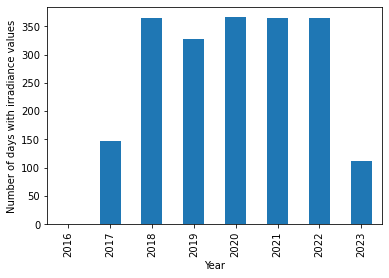

In [8]:
# assuming df2 is the DataFrame with referenceTime and value columns
# create a new column with the year
df_daily['year'] = pd.DatetimeIndex(df_daily['referenceTime']).year

# group by year and count the number of unique days
counts = df_daily.groupby('year')['referenceTime'].nunique()

# plot the results
counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of days with irradiance values')
plt.show()


From the last graph we can see that 2016 is not representative, so we will discard it from now on.


Now we want to see in each year how is the distribution of the samples taken.

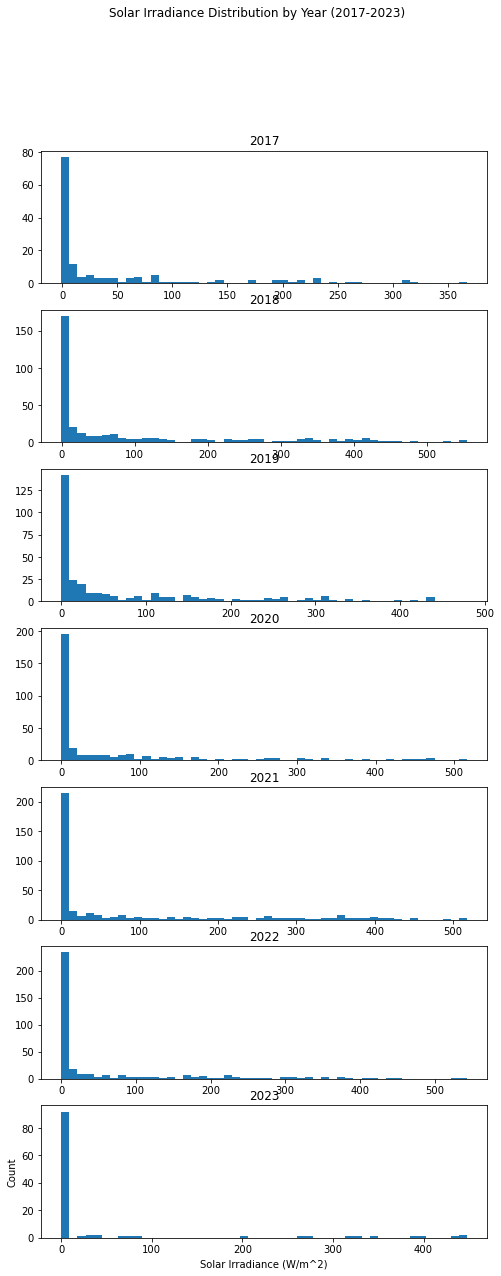

In [9]:

# Create subplots with 7 rows and 1 column
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 20))

# Iterate over each subplot and plot the histogram for each year
for i, ax in enumerate(axes):
    year = 2017 + i
    df_year = df_daily[df_daily['referenceTime'].dt.year == year]
    ax.hist(df_year['value'], bins=50)
    ax.set_title(f'{year}')

# Add axis labels and a title to the plot
fig.suptitle('Solar Irradiance Distribution by Year (2017-2023)')
plt.xlabel('Solar Irradiance (W/m^2)')
plt.ylabel('Count')
plt.show()


The above graphs made us think that there are too many values close to 0. That is a bit weird so we will see closer to an specific day and year. We choose 2020 to look closer.

In [10]:
# Filter the year 2020
df_2020 = df_daily[df_daily['year'] == 2020]

# Create bins for the histogram
bins = [0, 100, 200, 300]

# Count the number of values in each bin
hist, edges = np.histogram(df_2020['value'], bins=bins)

# Print the histogram counts
print("Number of values between 0 and 100:", hist[0])
print("Number of values between 100 and 200:", hist[1])
print("Number of values between 200 and 300:", hist[2])


Number of values between 0 and 100: 273
Number of values between 100 and 200: 33
Number of values between 200 and 300: 21


Almost most of the days of the year are between 0 and 100 W/m2. We will see closer, through plotting every samples for 2020 in a bar plot.

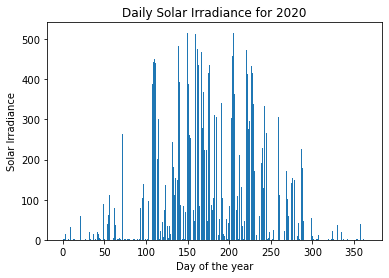

In [11]:
# Filter the DataFrame to keep only the rows for the year 2018
df_2020 = df_daily[df_daily['year'] == 2020]

# Create a new DataFrame with date as index and daily values as column
df_2020_daily = df_2020.set_index('referenceTime')[
    'value'].resample('D').mean().reset_index()

# Create a bar plot with 365 days on the x-axis and daily values on the y-axis
plt.bar(df_2020_daily.index, df_2020_daily['value'])

# Customize the plot with axis labels and title
plt.xlabel('Day of the year')
plt.ylabel('Solar Irradiance')
plt.title('Daily Solar Irradiance for 2020')
plt.show()


Above we can see that even in march there were so many values close to "0 W/m2". We filter "df2" table to see how were the measurements made on "2020-03-29".

In [12]:

# Filter the dataframe to the desired date
desired_date = pd.to_datetime('2020-03-29').date()
filtered_df = df2[df2['referenceTime'].dt.date == desired_date]
filtered_df


,sourceId,referenceTime,elementId,value,unit,timeOffset
22183,SN50539:0,2020-03-29 00:00:00+00:00,mean(solar_irradiance PT1H),0.000,W/m2,PT0H
22184,SN50539:0,2020-03-29 01:00:00+00:00,mean(solar_irradiance PT1H),0.000,W/m2,PT0H
22185,SN50539:0,2020-03-29 02:00:00+00:00,mean(solar_irradiance PT1H),0.000,W/m2,PT0H
22186,SN50539:0,2020-03-29 03:00:00+00:00,mean(solar_irradiance PT1H),0.000,W/m2,PT0H
22187,SN50539:0,2020-03-29 04:00:00+00:00,mean(solar_irradiance PT1H),0.000,W/m2,PT0H
22188,SN50539:0,2020-03-29 05:00:00+00:00,mean(solar_irradiance PT1H),1.072,W/m2,PT0H
22189,SN50539:0,2020-03-29 06:00:00+00:00,mean(solar_irradiance PT1H),0.000,W/m2,PT0H
22190,SN50539:0,2020-03-29 07:00:00+00:00,mean(solar_irradiance PT1H),0.809,W/m2,PT0H
22191,SN50539:0,2020-03-29 08:00:00+00:00,mean(solar_irradiance PT1H),0.579,W/m2,PT0H
22192,SN50539:0,2020-03-29 09:00:00+00:00,mean(solar_irradiance PT1H),0.000,W/m2,PT0H


We identified that there are some weirds lectures of solar irradiation. Most of the lectures are "0" even in the afternoon which may make us think that something might be wrong on the lecture of the data. But we decided to move forward.

We can see below the average per year, we can see that on 2018 had the highest average. 

In [13]:
yearly_avg = df_daily.groupby(df_daily["referenceTime"].dt.year)["value"].mean()
yearly_avg


referenceTime
2016      0.737000
2017     48.665130
2018    102.817962
2019     80.811857
2020     79.947009
2021     77.014838
2022     58.094770
2023     38.994755
Name: value, dtype: float64

Here We want to see how many samples were taken per month, so if every day during a month samples were taken we should see values close to 30 - 31 samples.

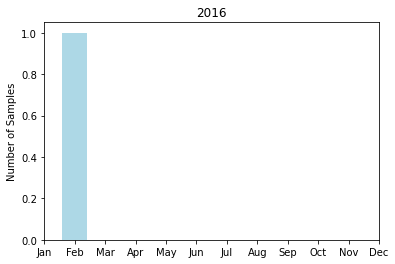

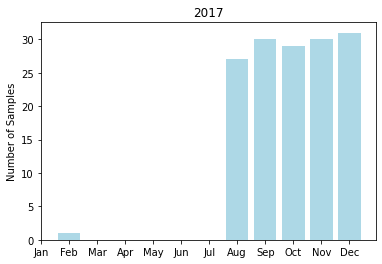

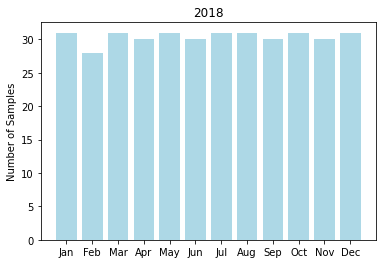

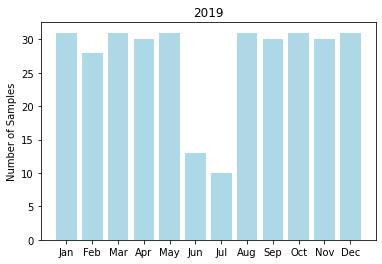

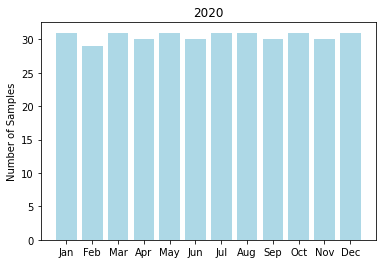

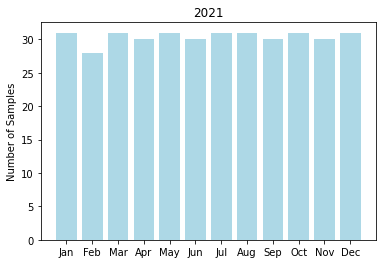

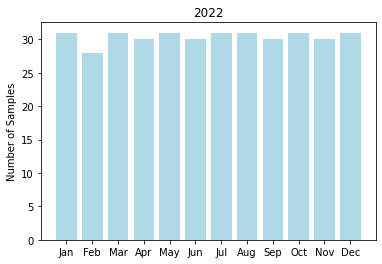

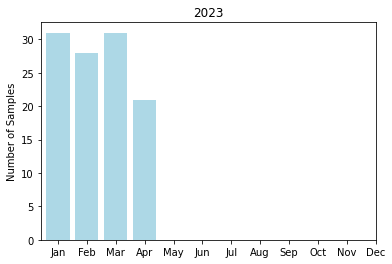

In [14]:
# Group by year and month
grouped = df_daily.groupby([df_daily['referenceTime'].dt.year,
                            df_daily['referenceTime'].dt.month])
# Get the count of samples for each group
counts = grouped.size()

# Loop over each year
for year in range(2016, 2024):
    # Create a new figure for each year
    plt.figure()
    plt.title(str(year))

    # Loop over each month
    for month in range(1, 13):
        # Check if there are any samples for this month and year
        if (year, month) in counts.index:
            # Get the count of samples for this month and year
            count = counts.loc[(year, month)]
            # Plot the count as a bar
            plt.bar(month, count, color="lightblue")

    # Set the x-axis label to show the month names
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr',
               'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    # Set the y-axis label
    plt.ylabel('Number of Samples')

    # Save the figure
    plt.savefig(f'sample_count_{year}.png')


We have decided to work only with the years where the data is completed (2018,2020,2021,2022). We keep 2023 data to compare estimations later on.

Here we did an average per month each year, since before we had samples average per day. We created another table called "df_monthly" to storage this information.

In [15]:
df_monthly = df2.groupby(pd.Grouper(key='referenceTime', freq='M'))[
    'value'].mean().reset_index()  # group by day and take mean
df_monthly = df_monthly.dropna(subset=['value']).reset_index(drop=True)

# extract the year from referenceTime
df_monthly['year'] = df_monthly['referenceTime'].dt.year

# filter the DataFrame based on the desired years
years = [2018, 2020, 2021, 2022, 2023]
df_monthly = df_monthly[df_monthly['year'].isin(years)]

# drop the 'year' column
df_monthly.drop('year', axis=1, inplace=True)

df_monthly = df_monthly.reset_index(drop=True)

df_monthly


,referenceTime,value
0,2018-01-31 00:00:00+00:00,12.893884
1,2018-02-28 00:00:00+00:00,53.589844
2,2018-03-31 00:00:00+00:00,123.750011
3,2018-04-30 00:00:00+00:00,113.232876
4,2018-05-31 00:00:00+00:00,274.477007
5,2018-06-30 00:00:00+00:00,219.122131
6,2018-07-31 00:00:00+00:00,230.426753
7,2018-08-31 00:00:00+00:00,90.421403
8,2018-09-30 00:00:00+00:00,32.905474
9,2018-10-31 00:00:00+00:00,47.286329


Now we want to graph each year and see how each month the value of solar irradation change

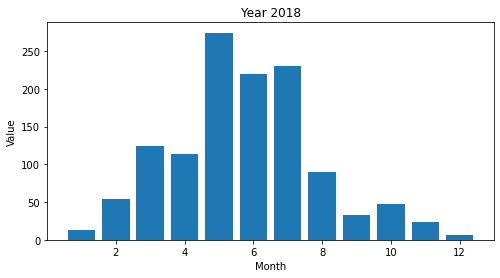

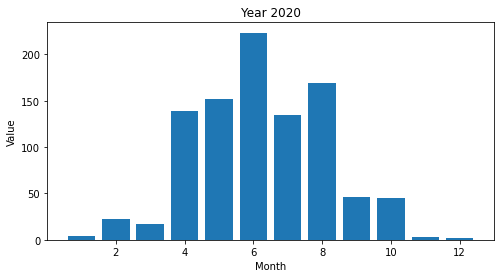

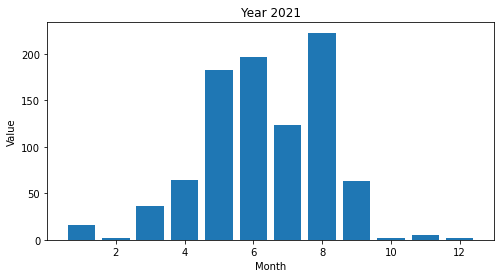

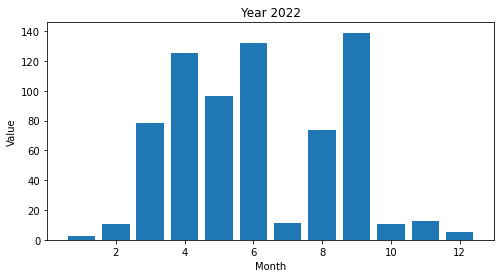

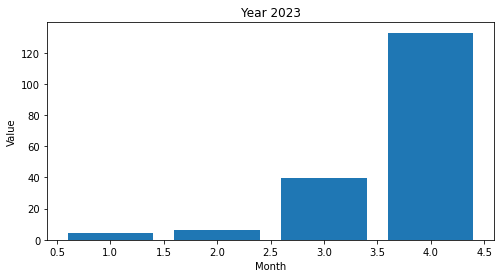

In [16]:

# create a separate plot for each year
years = df_monthly['referenceTime'].dt.year.unique()
for year in years:
    # filter the grouped DataFrame by year
    df_year = df_monthly[df_monthly['referenceTime'].dt.year == year]

    # create a bar plot of the monthly values for the year
    plt.figure(figsize=(8, 4))
    plt.bar(df_year['referenceTime'].dt.month, df_year['value'])
    plt.title(f'Year {year}')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.show()


We can see how on summer solar irradiance increase its value. Also, how in winter decrease significantly.

### Estimation Solar irradiance for 2023

Geometric Brownian Motion (GBM) and Geometric Ornstein-Uhlenbeck Process (GOU) are typically used to model stock prices and financial data, where the underlying process is assumed to be continuous and stationary over time. However, solar irradiance measurements are influenced by many factors that are not stationary, such as weather patterns, atmospheric conditions, and time of day. The cyclic nature of the solar irradiance data, combined with the non-stationary nature of the underlying process, makes it difficult to use GBM and GOU models to accurately estimate solar irradiance measurements.

Therefore we have decided to do estimation using Random Forest because it can handle non-stationary data and capture the complex interactions between different features that affect solar irradiance, such as weather patterns, time of day, and seasonal changes. Random Forest models are able to account for the nonlinear relationships between these features, which makes them a good choice for modeling solar irradiance data.

We filter the table we had by months "df_monthly" so we do not have 2023 data.

In [17]:
desired_date = pd.to_datetime('2022-12-31')
df_monthly_wo_2023 = df_monthly[df_monthly['referenceTime'].dt.year <=
                                desired_date.year]
df_monthly_wo_2023


,referenceTime,value
0,2018-01-31 00:00:00+00:00,12.893884
1,2018-02-28 00:00:00+00:00,53.589844
2,2018-03-31 00:00:00+00:00,123.750011
3,2018-04-30 00:00:00+00:00,113.232876
4,2018-05-31 00:00:00+00:00,274.477007
5,2018-06-30 00:00:00+00:00,219.122131
6,2018-07-31 00:00:00+00:00,230.426753
7,2018-08-31 00:00:00+00:00,90.421403
8,2018-09-30 00:00:00+00:00,32.905474
9,2018-10-31 00:00:00+00:00,47.286329


Here we will create a models array with a model for each month across all the years, since for example the idea it is to estimate January 2023, taking into account January month of 2018,2020,2021 and 2022

In [19]:


# Extract the year and month from the "referenceTime" column
df_monthly_wo_2023 = df_monthly_wo_2023.assign(
    year=df_monthly_wo_2023['referenceTime'].dt.year)
df_monthly_wo_2023 = df_monthly_wo_2023.assign(
    month=df_monthly_wo_2023['referenceTime'].dt.month)

# Create a list to store the trained models
models = []

# Loop through each month
for month in range(1, 13):
    # Extract the X and y data for the current month across all years
    X_month = df_monthly_wo_2023[df_monthly_wo_2023['month']
                                 == month]['year'].values.reshape(-1, 1)
    y_month = df_monthly_wo_2023[df_monthly_wo_2023['month']
                                 == month]['value'].values

    # Select data up to 2022-12-31 for training
    X_train = X_month[X_month[:, 0] < 2023]
    y_train = y_month[X_month[:, 0] < 2023]

    # Train a random forest regressor model for the current month
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Add the trained model to the list of models
    models.append(model)


Here we make predicitons for each of the months of 2023 so at the end we will have an array of 12 estimations.

In [20]:
# Use the trained models to predict values for January to December 2023
X_test = pd.date_range(start='2023-01-01', end='2023-12-01',
                       freq='MS').to_numpy().reshape(-1, 1)


y_pred_energ_produced = np.zeros(12)

for month in range(1, 13):
    # Extract the X data for the current month in 2023
    X_month = X_test[np.where(X_test[:, 0].astype(
        'datetime64[M]').astype(int) % 12 + 1 == month)]
    


    # Predict the y values for the current month in 2023
    model = models[month - 1]

    y_month = model.predict(X_month)
    
    y_pred_energ_produced[np.where(X_test[:, 0].astype('datetime64[M]').astype(
        int) % 12 + 1 == month)] = y_month


Here we compare the values that we already have for 2023 and the ones we have predicted for January, February and March

In [21]:
start_date = '2023-01-01'
end_date = '2023-03-31'
filtered_df = df_monthly[(df_monthly['referenceTime'] >= start_date)
                         & (df_monthly['referenceTime'] <= end_date)]

# Corroborate predicted values for January, February, and March 2023
actual_values = filtered_df['value'].to_numpy()
predicted_values = y_pred_energ_produced[:3]

for actual, predicted in zip(actual_values, predicted_values):
    print(f"Actual value: {actual:.2f}  Predicted value: {predicted:.2f}")


Actual value: 4.17  Predicted value: 5.56
Actual value: 6.26  Predicted value: 9.83
Actual value: 39.75  Predicted value: 64.81


The rest of the months solar irradiance values are here.

In [22]:
# Print predicted values for April to December 2023
for i, value in enumerate(y_pred_energ_produced[3:], start=4):
    print(f"Predicted value for {i:02d}-2023: {value:.2f}")


Predicted value for 04-2023: 112.62
Predicted value for 05-2023: 119.25
Predicted value for 06-2023: 152.62
Predicted value for 07-2023: 44.46
Predicted value for 08-2023: 113.46
Predicted value for 09-2023: 115.86
Predicted value for 10-2023: 11.27
Predicted value for 11-2023: 10.47
Predicted value for 12-2023: 4.32


Now we have to add all these values that we estimated from March/2023 until Dec/2023 into the already created table that has every month solar irradiance average "df_monthly".

In [23]:
# create a dataframe with the new rows
new_rows = pd.DataFrame({
    'referenceTime': ['2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'],
    'value': y_pred_energ_produced[4:]
})
new_rows['referenceTime'] = pd.to_datetime(new_rows['referenceTime'])
new_rows['referenceTime'] = new_rows['referenceTime'].dt.strftime(
    '%Y-%m-%d %H:%M:%S+00:00')

# append the new rows to the existing dataframe
df_monthly = df_monthly.append(new_rows, ignore_index=True)
df_monthly


,referenceTime,value
0,2018-01-31 00:00:00+00:00,12.893884
1,2018-02-28 00:00:00+00:00,53.589844
2,2018-03-31 00:00:00+00:00,123.750011
3,2018-04-30 00:00:00+00:00,113.232876
4,2018-05-31 00:00:00+00:00,274.477007
5,2018-06-30 00:00:00+00:00,219.122131
6,2018-07-31 00:00:00+00:00,230.426753
7,2018-08-31 00:00:00+00:00,90.421403
8,2018-09-30 00:00:00+00:00,32.905474
9,2018-10-31 00:00:00+00:00,47.286329


Here corroborate that the "referenceTime" column has the same format for all values.

In [24]:
df_monthly['referenceTime'] = pd.to_datetime(
    df_monthly['referenceTime'], utc=True
)

df_monthly['referenceTime'] = df_monthly['referenceTime'].dt.tz_convert(None)
df_monthly['referenceTime'] = pd.to_datetime(
    df_monthly['referenceTime'], format='%Y-%m-%d %H:%M:%S'
)


Here we calculated the variances for each month across all the years.

In [25]:
# Extract the month from the referenceTime column
df_monthly['month'] = df_monthly['referenceTime'].dt.month

# Calculate the variance for each month across all years studied
variances = []
for month in range(1, 13):
    # Extract the data for the current month
    data = df_monthly.loc[df_monthly['month'] == month, 'value']

    # Calculate the variance for the current month
    variance = np.var(data)

    # Add the variance to the list
    variances.append({'month': month, 'variance': variance})

# Convert the list of variances to a pandas DataFrame
variances_df = pd.DataFrame(variances)





Here we calculated the standard deviation for each month, the mean and the porcentage of uncertainty.

In [26]:
# Calculate the standard deviation for each month
variances_df['std_dev'] = variances_df['variance'].apply(np.sqrt)

# Calculate the mean for each month
means = []
for month in range(1, 13):
    # Extract the data for the current month
    data = df_monthly.loc[df_monthly['month'] == month, 'value']

    # Calculate the mean for the current month
    mean = np.mean(data)

    # Add the mean to the list
    means.append(mean)

# Add the means to the variances_df DataFrame
variances_df['mean'] = means

# Calculate the percentage of uncertainty for each month
variances_df['uncertainty_percent'] = (
    variances_df['std_dev'] / variances_df['mean']) * 100
variances_df


,month,variance,std_dev,mean,uncertainty_percent
0,1,30.973371,5.565372,8.023531,69.363137
1,2,342.787940,18.514533,19.207978,96.389811
2,3,1439.967608,37.946905,59.068459,64.242247
3,4,720.717890,26.846189,114.799413,23.385302
4,5,3861.559880,62.141451,164.923150,37.679035
5,6,1325.091816,36.401811,184.748096,19.703484
6,7,5861.633925,76.561308,108.705023,70.430331
7,8,3011.692712,54.878891,134.035914,40.943423
8,9,1680.513323,40.994064,79.464675,51.587783
9,10,364.668378,19.096292,23.279961,82.028885


To have better understanding of the data , we plot the mean and the variance for each month. Here hsitorical and predicted value is taken into account.

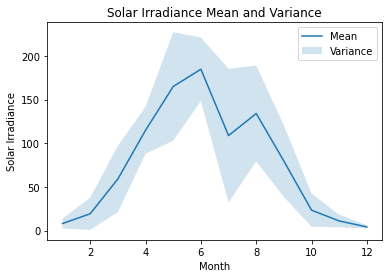

In [27]:
# Plot the mean solar irradiance for each month
plt.plot(variances_df['month'], variances_df['mean'], label='Mean')

# Plot the variance as a shaded area around the mean
plt.fill_between(variances_df['month'], variances_df['mean'] - variances_df['std_dev'],
                 variances_df['mean'] + variances_df['std_dev'], alpha=0.2, label='Variance')

# Set the title and axis labels
plt.title('Solar Irradiance Mean and Variance')
plt.xlabel('Month')
plt.ylabel('Solar Irradiance')

# Add a legend
plt.legend()

# Show the plot
plt.show()


surprisingly, on winter season there is less variance, on the hand during summer (July) is where we have the biggest variance. 

### Estimation of how much energy can be produced from a solar panel

Now we want to estimate how much energy can be produced from a solar panel having the solar irradiance we calculated before.

Power = Area x Efficiency x Solar Irradiance

The average area is 1.6 m^2 to 2 m^2 and efficiency is 15% to 22% of a solar panel.

In [28]:
df_monthly["Power (Watts)"]= df_monthly['value']*1.6*0.15

In [29]:
df_monthly["Energy (Watts*h)"]= df_monthly['Power (Watts)']*12

In [30]:
# rename the columns
df_monthly = df_monthly.rename(
    columns={'value': 'Sollar Irradiance (W/m2)'})
df_monthly = df_monthly.drop('month', axis=1)


We decided to be negative and use the most small solar panels with less eficiency

In [31]:
df_monthly


,referenceTime,Sollar Irradiance (W/m2),Power (Watts),Energy (Watts*h)
0,2018-01-31,12.893884,3.094532,37.134387
1,2018-02-28,53.589844,12.861563,154.338750
2,2018-03-31,123.750011,29.700003,356.400031
3,2018-04-30,113.232876,27.175890,326.110684
4,2018-05-31,274.477007,65.874482,790.493779
5,2018-06-30,219.122131,52.589311,631.071736
6,2018-07-31,230.426753,55.302421,663.629050
7,2018-08-31,90.421403,21.701137,260.413641
8,2018-09-30,32.905474,7.897314,94.767764
9,2018-10-31,47.286329,11.348719,136.184627


## Electricity Consumption

Now we want to find how the electricity comsuption has been through the same years that we have studied before. The data was taken from (Ref 3.).

First we download the data from 2018 and read it.

In [32]:
# read the Excel file into a pandas dataframe
df_2018_electricity = pd.read_excel('12824_20230425-103240.xlsx')
# remove the last 36 rows and keep only the first two columns
df_2018_electricity = df_2018_electricity.iloc[:-36, :2]
df_2018_electricity['Unnamed: 0'] = pd.to_datetime(
    df_2018_electricity['Unnamed: 0'])
df_2018_electricity.rename(
    columns={'Unnamed: 0': 'referenceTime'}, inplace=True)


df_2018_electricity['referenceTime'] = df_2018_electricity['referenceTime'].dt.strftime(
    '%Y-%m-%d %H:%M:%S+00:00')



Now we do the same with the data from 2020 to 2023

In [33]:

# read the Excel file into a pandas dataframe
df_2020_2023_electricity = pd.read_excel('12824_20230425-111708.xlsx')
df_2020_2023_electricity['Unnamed: 0'] = pd.to_datetime(df_2020_2023_electricity['Unnamed: 0'])
df_2020_2023_electricity.rename(columns={
                                'Unnamed: 0': "referenceTime", 'Unnamed: 1': "Net consumption of electricity Norway (Kwh)"}, inplace=True)
df_2020_2023_electricity=df_2020_2023_electricity.drop(columns='Unnamed: 2')

df_2020_2023_electricity['referenceTime'] = df_2020_2023_electricity['referenceTime'].dt.strftime(
    '%Y-%m-%d %H:%M:%S+00:00')
# print the dataframe



We merge both data frames to have a final table called "df_concat_electricty"

In [34]:
df_concat_electricty = pd.concat(
    [df_2018_electricity, df_2020_2023_electricity], ignore_index=True)
df_concat_electricty


,referenceTime,Net consumption of electricity Norway (Kwh)
0,2018-01-01 00:00:00+00:00,13505959.0
1,2018-02-01 00:00:00+00:00,12459903.0
2,2018-03-01 00:00:00+00:00,13245245.0
3,2018-04-01 00:00:00+00:00,10474895.0
4,2018-05-01 00:00:00+00:00,8777033.0
5,2018-06-01 00:00:00+00:00,8082914.0
6,2018-07-01 00:00:00+00:00,7743382.0
7,2018-08-01 00:00:00+00:00,8251207.0
8,2018-09-01 00:00:00+00:00,8757348.0
9,2018-10-01 00:00:00+00:00,10544820.0


We remove 2023 data from above table and have new table "df_concat_electricty_wo_2023"

In [35]:
df_concat_electricty['referenceTime'] = pd.to_datetime(
    df_concat_electricty['referenceTime'])
desired_date = pd.to_datetime('2022-12-31')
df_concat_electricty_wo_2023 = df_concat_electricty[df_concat_electricty['referenceTime'].dt.year <=
                                desired_date.year]



We want to see now how the comsuption of electricty has been through the years.

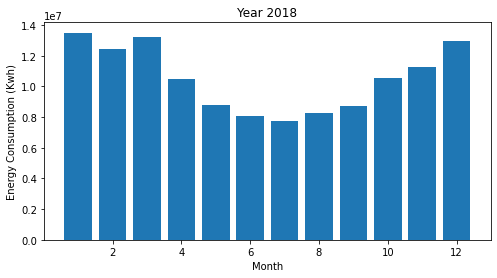

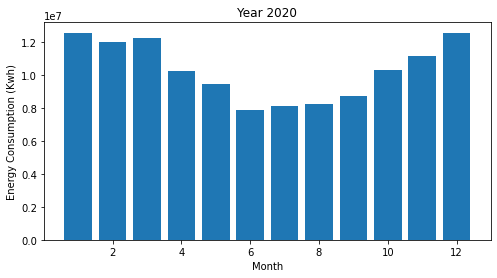

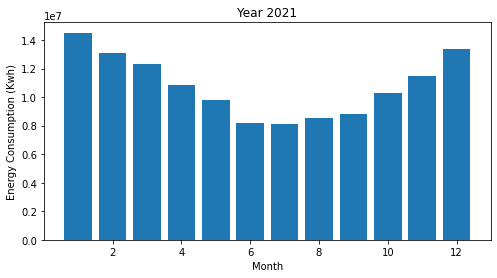

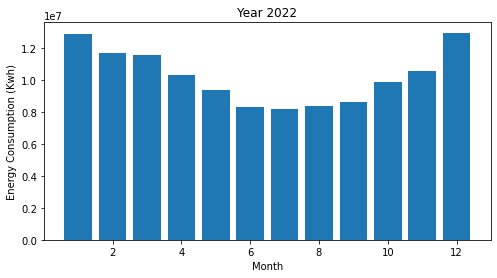

In [36]:
# create a separate plot for each year
years = df_concat_electricty_wo_2023['referenceTime'].dt.year.unique()
for year in years:
    # filter the grouped DataFrame by year
    df_year = df_concat_electricty_wo_2023[df_concat_electricty_wo_2023['referenceTime'].dt.year == year]

    # create a bar plot of the monthly values for the year
    plt.figure(figsize=(8, 4))
    plt.bar(df_year['referenceTime'].dt.month,
            df_year['Net consumption of electricity Norway (Kwh)'])
    plt.title(f'Year {year}')
    plt.xlabel('Month')
    plt.ylabel('Energy Consumption (Kwh)')
    plt.show()


As we expected during summer electricty comsuption is less.

We have a model for each month across all the years, since it is cycling information. January 2023 will be influenced by the January of 2018,2020,2021 and 2022.

In [37]:
# Extract the year and month from the "referenceTime" column
df_concat_electricty_wo_2023 = df_concat_electricty_wo_2023.assign(
    year=df_concat_electricty_wo_2023['referenceTime'].dt.year)
df_concat_electricty_wo_2023 = df_concat_electricty_wo_2023.assign(
    month=df_concat_electricty_wo_2023['referenceTime'].dt.month)


# Create a list to store the trained models
models = []

# Loop through each month
for month in range(1, 13):
    # Extract the X and y data for the current month across all years
    X_month = df_concat_electricty_wo_2023[df_concat_electricty_wo_2023['month']
                                 == month]['year'].values.reshape(-1, 1)
    y_month = df_concat_electricty_wo_2023[df_concat_electricty_wo_2023['month']
                                           == month]['Net consumption of electricity Norway (Kwh)'].values

    # Select data up to 2022-12-31 for training
    X_train = X_month[X_month[:, 0] < 2023]
    y_train = y_month[X_month[:, 0] < 2023]

    # Train a random forest regressor model for the current month
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Add the trained model to the list of models
    models.append(model)


Here we do the prediciton for each month in 2023, so at the end we will have an array of 12 predictions.

In [38]:
# Use the trained models to predict values for January to December 2023
X_test = pd.date_range(start='2023-01-01', end='2023-12-01',
                       freq='MS').to_numpy().reshape(-1, 1)


y_pred_energy_consumed = np.zeros(12)

for month in range(1, 13):
    # Extract the X data for the current month in 2023
    X_month = X_test[np.where(X_test[:, 0].astype(
        'datetime64[M]').astype(int) % 12 + 1 == month)]

    # Predict the y values for the current month in 2023
    model = models[month - 1]

    y_month = model.predict(X_month)

    y_pred_energy_consumed[np.where(X_test[:, 0].astype('datetime64[M]').astype(
        int) % 12 + 1 == month)] = y_month


Here we compare the actual information that we have for 2023 and the predicitons done.

In [39]:
start_date = '2023-01-01'
end_date = '2023-03-31'
filtered_df = df_concat_electricty[(df_concat_electricty['referenceTime'] >= start_date)
                                   & (df_concat_electricty['referenceTime'] <= end_date)]

# Corroborate predicted values for January, February, and March 2023
actual_values = filtered_df['Net consumption of electricity Norway (Kwh)'].to_numpy(
)
predicted_values = y_pred_energy_consumed[:3]

for actual, predicted in zip(actual_values, predicted_values):
    print(f"Actual value: {actual:.2f}  Predicted value: {predicted:.2f}")


Actual value: 12731304.00  Predicted value: 13235792.70
Actual value: 11072007.00  Predicted value: 12016100.51
Actual value: 12488414.00  Predicted value: 11790148.76


Here we show the predictions of how is going to be the electricity comsuption for the rest of the months of 2023.

In [40]:
# Print predicted values for April to December 2023
for i, value in enumerate(y_pred_energy_consumed[3:], start=4):
    print(f"Predicted value for {i:02d}-2023: {value:.2f}")


Predicted value for 04-2023: 10421398.74
Predicted value for 05-2023: 9495146.00
Predicted value for 06-2023: 8242208.19
Predicted value for 07-2023: 8187525.34
Predicted value for 08-2023: 8415563.72
Predicted value for 09-2023: 8664797.70
Predicted value for 10-2023: 10012219.80
Predicted value for 11-2023: 10799841.15
Predicted value for 12-2023: 13028630.23


Here we merged the data that we predict and the table we had before. Creating a new table "df_concat_electricty"

In [41]:
# create a dataframe with the new rows
new_rows = pd.DataFrame({
    'referenceTime': ['2023-04-30','2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'],
    'Net consumption of electricity Norway (Kwh)': y_pred_energy_consumed[3:]
})
new_rows['referenceTime'] = pd.to_datetime(new_rows['referenceTime'])
new_rows['referenceTime'] = new_rows['referenceTime'].dt.strftime(
    '%Y-%m-%d %H:%M:%S+00:00')

# append the new rows to the existing dataframe
df_concat_electricty = df_concat_electricty.append(new_rows, ignore_index=True)



Here we make sure the "refecenreTime" column has the same format in all rows.

In [42]:
df_concat_electricty['referenceTime'] = pd.to_datetime(
    df_concat_electricty['referenceTime'], utc=True
)

df_concat_electricty['referenceTime'] = df_concat_electricty['referenceTime'].dt.tz_convert(
    None)
df_concat_electricty['referenceTime'] = pd.to_datetime(
    df_concat_electricty['referenceTime'], format='%Y-%m-%d %H:%M:%S'
)



Here we found the variance for each month across all the estudied years.

In [43]:
# Extract the month from the referenceTime column
df_concat_electricty['month'] = df_concat_electricty['referenceTime'].dt.month

# Calculate the variance for each month across all years studied
variances = []
for month in range(1, 13):
    # Extract the data for the current month
    data = df_concat_electricty.loc[df_concat_electricty['month'] ==
                                    month, 'Net consumption of electricity Norway (Kwh)']

    # Calculate the variance for the current month
    variance = np.var(data)

    # Add the variance to the list
    variances.append({'month': month, 'variance': variance})

# Convert the list of variances to a pandas DataFrame
variances_df_comsuption = pd.DataFrame(variances)
variances_df_comsuption

# Calculate the standard deviation for each month
variances_df_comsuption['std_dev'] = variances_df_comsuption['variance'].apply(
    np.sqrt)





Now we calculated the standard deviation, the mean and the uncertainty percentage for each month.

In [44]:
# Calculate the mean for each month
means = []
for month in range(1, 13):
    # Extract the data for the current month
    data = df_concat_electricty.loc[df_concat_electricty['month']
                                    == month, 'Net consumption of electricity Norway (Kwh)']

    # Calculate the mean for the current month
    mean = np.mean(data)

    # Add the mean to the list
    means.append(mean)

# Add the means to the variances_df DataFrame
variances_df_comsuption['mean'] = means

# Calculate the percentage of uncertainty for each month
variances_df_comsuption['uncertainty_percent'] = (
    variances_df_comsuption['std_dev'] / variances_df_comsuption['mean']) * 100
variances_df_comsuption


,month,variance,std_dev,mean,uncertainty_percent
0,1,5.058895e+11,711259.120849,1.324151e+07,5.371434
1,2,4.580696e+11,676808.396757,1.205393e+07,5.614834
2,3,2.838018e+11,532730.553563,1.236874e+07,4.307074
3,4,4.154269e+10,203820.241461,1.045306e+07,1.949861
4,5,1.133747e+11,336711.553503,9.390407e+06,3.585697
5,6,2.355277e+10,153469.121226,8.137655e+06,1.885913
6,7,2.906457e+10,170483.338604,8.070346e+06,2.112466
7,8,1.299450e+10,113993.405801,8.373530e+06,1.361354
8,9,3.932495e+09,62709.606708,8.714422e+06,0.719607
9,10,5.072596e+10,225224.244763,1.020519e+07,2.206958


Uncertainty is less that than energy produced uncertainty. We guess that the consumption has less factors that can affect it.

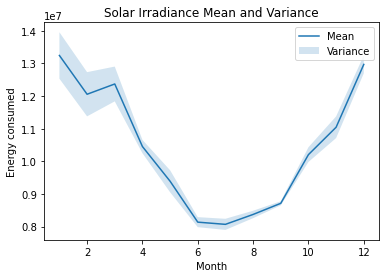

In [45]:
# Plot the mean solar irradiance for each month
plt.plot(variances_df_comsuption['month'],
         variances_df_comsuption['mean'], label='Mean')

# Plot the variance as a shaded area around the mean
plt.fill_between(variances_df_comsuption['month'], variances_df_comsuption['mean'] - variances_df_comsuption['std_dev'],
                 variances_df_comsuption['mean'] + variances_df_comsuption['std_dev'], alpha=0.2, label='Variance')

# Set the title and axis labels
plt.title('Solar Irradiance Mean and Variance')
plt.xlabel('Month')
plt.ylabel('Energy consumed')

# Add a legend
plt.legend()

# Show the plot
plt.show()


### Comparison between Energy Produced and Energy consumed

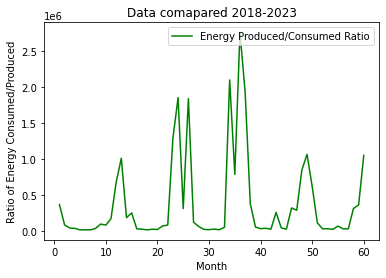

In [46]:


# Calculate the ratio of energy produced to energy consumed for each month
ratio = df_concat_electricty["Net consumption of electricity Norway (Kwh)"] / df_monthly['Energy (Watts*h)']


# Plot the ratio
plt.plot(range(1, 61), ratio, color='green',
         label='Energy Produced/Consumed Ratio')


# Add labels and legend
plt.title("Data comapared 2018-2023")
plt.xlabel('Month')
plt.ylabel('Ratio of Energy Consumed/Produced')
plt.legend()

# Show the plot
plt.show()


Energy comsuption has less variance than enery produced since less volatile factors affects it. Climate changes will affect every year more making more difficult to predict the energy produced form solar panels. We can see from the graph that even on 2021 there was a peak , a pattern aorund of 1 million of solar panels are required this can be less if we use bigger and more efficient solar panels.

Also, it is important to mention that only data from one station that is located in Bergen was used for this analysis. Having said this, values  fo solar panels can also be less if we would have been able to acces to information of zones where solar irradiance can be higher. Also some energy can be transported from counties that receive more solar irradiance to the ones that receive less.

Historical data it is really important to perform predictions since can help us to make narrower our action-frame-windows. Here we used Random Forest and we got quite accurate predictions for 2023, but it is important to have in mind that there are nowdays some ohter algortihms that take into account different factors make them more accurate like XGBOOST.